<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Classes-for-building-up-a-computation-graph" data-toc-modified-id="Classes-for-building-up-a-computation-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Classes for building up a computation graph</a></span></li><li><span><a href="#Building-up-a-simple-computation-graph:-a-single-neuron" data-toc-modified-id="Building-up-a-simple-computation-graph:-a-single-neuron-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Building up a simple computation graph: a single neuron</a></span></li><li><span><a href="#Implementing-Backpropagation" data-toc-modified-id="Implementing-Backpropagation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Implementing Backpropagation</a></span></li><li><span><a href="#Let-us-train-a-single-neuron-to-learn-to-add-the-3-inputs" data-toc-modified-id="Let-us-train-a-single-neuron-to-learn-to-add-the-3-inputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Let us train a single neuron to learn to add the 3 inputs</a></span></li></ul></div>

# Introduction

MiniFlow is not TensorFlow.

It is a very minimalistic framework with the goal to introduce students into the idea of
- representing a neural network as a computation graph
- computing the gradient of the error function with respect to the model parameters by using Reverse-mode autodiff

# Classes for building up a computation graph

In [1]:
class node:
    """
    A graph node can just store a value
    """
    
    def __init__(self, name):
        self.name = name
        self.value = 0.0
        self._w = 0.0
        self.is_input_for = []
        
    def compute(self):
        pass
    
    def derive(self, w):
        pass
        


class node_op_unary(node):
    """
    Base class for unary operation nodes,
    e.g. Relu(x), abs(x)
    """
    
    def __init__(self, name, input1):
        node.__init__(self, name)
        self.input1 = input1
        input1.is_input_for.append( self )

        

class node_op_binary(node):
    """
    Base class for binary operation nodes,
    e.g. x*y, x+y, x-y
    """
    
    def __init__(self, name, input1, input2):
        node.__init__(self, name)
        self.input1 = input1
        self.input2 = input2
        input1.is_input_for.append( self )
        input2.is_input_for.append( self )


        
class node_op_mult(node_op_binary):
    """
    x*y
    """
    
    def __init__(self, name, input1, input2):
        node_op_binary.__init__(self, name, input1, input2)
    
    def compute(self):
        self.value = self.input1.value * self.input2.value
        
    def derive(self, w):
        """
        compute the derivative of this node
        with respect to node <w>
        """
        if w==self.input1:
            return self.input2.value
        elif w==self.input2:
            return self.input1.value
        

        
class node_op_add(node_op_binary):
    """
    x+y
    """
    
    def __init__(self, name, input1, input2):
        node_op_binary.__init__(self, name, input1, input2)
    
    def compute(self):
        self.value = self.input1.value + self.input2.value
        
    def derive(self, w):
        """
        compute the derivative of this node
        with respect to node <w>
        """
        if w == self.input1:
            return 1.0
        elif w == self.input2:
            return +1.0
        

        
class node_op_sub(node_op_binary):
    """
    x-y
    """
    
    def __init__(self, name, input1, input2):
        node_op_binary.__init__(self, name, input1, input2)
    
    def compute(self):
        self.value = self.input1.value - self.input2.value  
        
    def derive(self, w):
        """
        compute the derivative of this node
        with respect to node <w>
        """
        if w == self.input1:
            return 1.0
        elif w == self.input2:
            return -1.0
        

        
class node_op_relu(node_op_unary):
    """
    Relu(x)
    """
    
    def __init__(self, name, input1):
        node_op_unary.__init__(self, name, input1)
        
    def compute(self):
        """
        compute output of this node: Relu(input)
        """
        if self.input1.value < 0.0:
            self.value = 0.0
        else:
            self.value = self.input1.value
            
            
    def derive(self, w):
        """
        compute the derivative of this node
        with respect to node <w>
        """
        if w.value < 0.0:
            return 0.0
        else:
            return 1.0
            

            
class node_op_abs(node_op_unary):
    """
    abs(x)
    """
    
    def __init__(self, name, input1):
        node_op_unary.__init__(self, name, input1)
        
    def compute(self):
        """
        compute output of this node: abs(input)
        """
        self.value = abs(self.input1.value)
        
    def derive(self, w):
        """
        compute the derivative of this node
        with respect to node <w>
        """
        if w.value > 0.0:
            return 1.0
        elif w.value < 0:
            return -1.0
        else:
            return 0.0

# Building up a simple computation graph: a single neuron

The neuron will have 3 inputs and 3 weights will be learned.

In [2]:
# 3 input nodes
w1 = node("w1 (input)")
w2 = node("w2 (input)")
w3 = node("w3 (input)")

# 3 parameter nodes (weights)
w4 = node("w4 (weight)")
w5 = node("w5 (weight)")
w6 = node("w6 (weight)")

# computation of activation
w7 = node_op_mult("w7=w1*w4", w1,w4)
w8 = node_op_mult("w8=w2*w5", w2,w5)
w9 = node_op_mult("w9=w3*w6", w3,w6)
w10 = node_op_add("w10=w7+w8", w7,w8)
w11 = node_op_add("w11=w10+w9", w10,w9)

# computation of output value
w12 = node_op_relu("w12=relu(w11)", w11)

# teacher value
w13 = node("w13=teacher value")

# computation of loss
w14 = node_op_sub("w14=w13-w12", w13,w12)
w15 = node_op_abs("w15=abs(w14)", w14)

# add all generated nodes to a Python list
all_nodes = [w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12,w13,w14,w15]

def feedforward(all_nodes):
    """
    Let all nodes compute their outputs
    starting from the first node
    and going to the last node in the list
    """
    
    for n in all_nodes:
        n.compute()

In [3]:
w1.value = 2.0
w2.value = 1.0
w3.value = 1.0
w4.value = 10.0

feedforward(all_nodes)

In [4]:
w7.value

20.0

In [5]:
w11.value

20.0

In [6]:
w12.value

20.0

In [7]:
w13.value

0.0

In [8]:
w14.value

-20.0

In [9]:
w15.value

20.0

# Implementing Backpropagation

In [18]:
def backpropagation(all_nodes):
    """    
    For each computation node w, compute:
    
           d loss    d loss         d next_node
    _w =   ------ =  ----------- *  ----------- 
           d w       d next_node    d w
                        
         = next_node._w * dnext_dw
         = (how does the next node change the output?) *
           (how does this node change the output of the next node?)
          
    In other words: do reverse-mode autodiff
    """
    
    
    nr_nodes = len(all_nodes)
    
    # set seed variable
    all_nodes[-1]._w = 1.0
    
    # go through all nodes, but in reverse order
    for w in reversed( all_nodes[0:nr_nodes-1] ):
        
        # compute how this node
        # changes the output of the error node
        w._w = 0.0
        
        # multi-variate chain rule
        for next_node in w.is_input_for:
            # compute the derivative of the next node
            # with respect to node n
            dnext_dw = next_node.derive( w )
            #print("\tcomputing dnext_dw = d {} / d {} = {}"
            #      .format(next_node.name, w.name, dnext_dw) )
            #print("\tnext_node._w = ", next_node._w)
            w._w += next_node._w * dnext_dw
            
        #print("computed _{} = {}".format(w.name, w._w) )

In [19]:
backpropagation(all_nodes)

# Let us train a single neuron to learn to add the 3 inputs

We will start with random start weights and check whether the training procedure correctly sets the weights, such that the outputs are as desired:

In [71]:
from random import random
import numpy as np

# set start weights
w4.value = 0.2
w5.value = 1.3
w6.value = 0.8

show_debug_info = False
learn_rate = 0.01
steps = 2000
errors = []
for step in range(1,steps+1):
    
    if show_debug_info:
        print("step:", step)
    else:
        if step % (steps/100) == 0:
            print("step:", step)
            print("\t(w4,w5,w6) = ({:.4f},{:.4f},{:.4f})"
                  .format(w4.value, w5.value, w6.value) )
        
    
    # 1. randomly generate 3 input values
    w1.value = random()
    w2.value = random()
    w3.value = random()
    if show_debug_info:
        print("\tinput vec: ({0:.2},{1:.2},{2:.2})"
              .format(w1.value,w2.value,w3.value))
    
    # 2. compute and set teacher value
    w13.value = w1.value + w2.value + w3.value # test function 1
    #w13.value = w1.value + 2.0*w2.value + 3.0*w3.value # test function 2
    #w13.value = w1.value # test function 3
    #w13.value = w1.value+w3.value # test function 4
    #w13.value = w1.value*w1.value # test function 5
    
    # 3. forward propagation
    feedforward(all_nodes)
    
    # 4. compare actual output with teacher value
    if show_debug_info:
        print("\tis: {0:.2} vs. teacher: {1:.2}"
              .format(w12.value, w13.value))
    
    # 5. train (adapt) weights?
    if True:
            
        # 5.1 compute gradient
        backpropagation(all_nodes)
        
        # 5.2 show gradient
        if show_debug_info:
            print("\tThe gradient is: ({:.2f},{:.2f},{:.2f})"
                  .format(w4._w, w5._w, w6._w) )
        
        # 5.3 adapt weights
        w4.value += learn_rate * -w4._w
        w5.value += learn_rate * -w5._w
        w6.value += learn_rate * -w6._w
            
    # 6. compute error and store it in a list
    error = abs(w12.value - w13.value)
    errors.append( error )    

step: 20
	(w4,w5,w6) = (0.2931,1.3372,0.8572)
step: 40
	(w4,w5,w6) = (0.3929,1.3603,0.9190)
step: 60
	(w4,w5,w6) = (0.4675,1.4101,0.9830)
step: 80
	(w4,w5,w6) = (0.5276,1.4054,1.0038)
step: 100
	(w4,w5,w6) = (0.5699,1.3952,1.0050)
step: 120
	(w4,w5,w6) = (0.6186,1.3756,0.9908)
step: 140
	(w4,w5,w6) = (0.6202,1.2970,0.9551)
step: 160
	(w4,w5,w6) = (0.6697,1.2805,0.9883)
step: 180
	(w4,w5,w6) = (0.7242,1.2583,1.0087)
step: 200
	(w4,w5,w6) = (0.7493,1.2411,0.9998)
step: 220
	(w4,w5,w6) = (0.7930,1.2107,1.0166)
step: 240
	(w4,w5,w6) = (0.8143,1.1762,1.0096)
step: 260
	(w4,w5,w6) = (0.8567,1.1513,1.0301)
step: 280
	(w4,w5,w6) = (0.8856,1.1295,1.0214)
step: 300
	(w4,w5,w6) = (0.9073,1.1026,1.0281)
step: 320
	(w4,w5,w6) = (0.9442,1.0655,0.9965)
step: 340
	(w4,w5,w6) = (0.9791,1.0417,1.0074)
step: 360
	(w4,w5,w6) = (0.9903,1.0052,1.0032)
step: 380
	(w4,w5,w6) = (1.0082,1.0009,1.0021)
step: 400
	(w4,w5,w6) = (0.9936,1.0093,0.9900)
step: 420
	(w4,w5,w6) = (0.9988,0.9981,1.0006)
step: 440
	(w4,w5

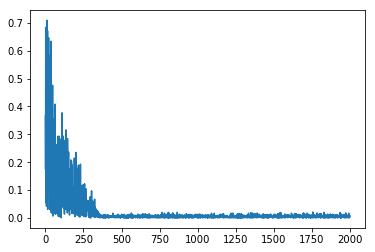

In [72]:
import matplotlib.pyplot as plt

plt.plot(errors)
plt.show()